**INTRODUCTION**

*Please visit the following [link](https://www.kaggle.com/code/gregoiredc/arrhythmia-on-ecg-classification-using-cnn) for the original notebook.*

Ce programme est destiné à l'étude des différents troubles d'ordre cardiologiques. Nous voulons créer un système intélligent capable de détecter si le sujet en question est un sujet normal ou présente un disfonctionnement cardiologique. Une base de signaux ECG est utilisée pour construire notre système intélligent. Nous ponsons utiliser les Réseaux de Neurone Artificiel (RNA). Différentes architectures des RNA ainsi différentes conditions ont été testées.

La première partie est consacrée à la préparation des données avant de les présenter au RNA. Rappelons que notre base [mitbih](https://www.kaggle.com/datasets/shayanfazeli/heartbeat), disponible dans [kagge](https://www.kaggle.com/). Voici un résumé des principales caractéristiques de la base :

    Number of Samples: 109446
    Number of Categories: 5
    Sampling Frequency: 125Hz
    Data Source: Physionet's MIT-BIH Arrhythmia Dataset
    Classes: ['N': 0, 'S': 1, 'V': 2, 'F': 3, 'Q': 4]
    -N : Non-ecotic beats (normal beat)
    -S : Supraventricular ectopic beats
    -V : Ventricular ectopic beats
    -F : Fusion Beats
    -Q : Unknown Beats


In this notebook i want to predict different arrhytmia on ECG. We have two different dataset, but i will consider at start only one : mitbih.
The MIT-BIH Arrhythmia Database contains 48 half-hour excerpts of two-channel ambulatory ECG recordings, obtained from 47 subjects studied by the BIH Arrhythmia Laboratory between 1975 and 1979. Twenty-three recordings were chosen at random from a set of 4000 24-hour ambulatory ECG recordings collected from a mixed population of inpatients (about 60%) and outpatients (about 40%) at Boston's Beth Israel Hospital; the remaining 25 recordings were selected from the same set to include less common but clinically significant arrhythmias that would not be well-represented in a small random sample.
souces : https://physionet.org/content/mitdb/1.0.0/




**What is an ecg? **

An electrocardiogram (ECG) is a simple test that can be used to check your heart's rhythm and electrical activity.

Sensors attached to the skin are used to detect the electrical signals produced by your heart each time it beats.

These signals are recorded by a machine and are looked at by a doctor to see if they're unusual.

An ECG may be requested by a heart specialist (cardiologist) or any doctor who thinks you might have a problem with your heart, including your GP.
That's the result of this test we will analyze. 

**Load Data**

La première étape consiste à télécharger la base (les fichier `*.csv`) et les sauvegader dans `Google Drive` (`'MiniProjet/ECG/P1/DatasetOld/'` dans notre cas). Cette étape permet de rendre accessible la base à `Google Colabs`.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!cd '/content/drive/MyDrive/MiniProjet/ECG/P1'

Mounted at /content/drive


In [ ]:
# Lister le contenu 
import os
pathDir = '/content/drive/MyDrive/MiniProjet/ECG/P1/DatasetOld/'
for dirname, _, filenames in os.walk(pathDir):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/content/drive/MyDrive/MiniProjet/ECG/P1/DatasetOld/mitbih_test.csv
/content/drive/MyDrive/MiniProjet/ECG/P1/DatasetOld/mitbih_train.csv
/content/drive/MyDrive/MiniProjet/ECG/P1/DatasetOld/ptbdb_abnormal.csv
/content/drive/MyDrive/MiniProjet/ECG/P1/DatasetOld/ptbdb_normal.csv


In [ ]:
# Charger les différents packages nécessaires
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from keras.utils.np_utils import to_categorical
from sklearn.utils import class_weight
import warnings
warnings.filterwarnings('ignore')


In [ ]:
# Récupérer les données des fichiers source
pathTrainFile = pathDir + 'mitbih_train.csv'
pathTestFile = pathDir + 'mitbih_test.csv'
train_df=pd.read_csv(pathTrainFile,header=None)
test_df=pd.read_csv(pathTestFile,header=None)

**Balance of dataset**

In [ ]:
train_df[187]=train_df[187].astype(int)
equilibre=train_df[187].value_counts()
print(equilibre)



0    72471
4     6431
2     5788
1     2223
3      641
Name: 187, dtype: int64


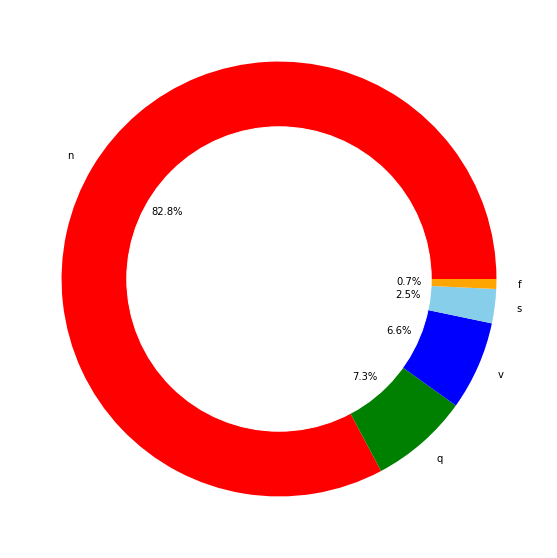

In [ ]:
plt.figure(figsize=(20,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(equilibre, labels=['n','q','v','s','f'], colors=['red','green','blue','skyblue','orange'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

We can underligned a huge difference in the balanced of the classes. After some try i have decided to  choose the resample technique more than the class weights for the algorithms. 

In [ ]:
from sklearn.utils import resample
df_1=train_df[train_df[187]==1]
df_2=train_df[train_df[187]==2]
df_3=train_df[train_df[187]==3]
df_4=train_df[train_df[187]==4]
df_0=(train_df[train_df[187]==0]).sample(n=20000,random_state=42)

df_1_upsample=resample(df_1,replace=True,n_samples=20000,random_state=123)
df_2_upsample=resample(df_2,replace=True,n_samples=20000,random_state=124)
df_3_upsample=resample(df_3,replace=True,n_samples=20000,random_state=125)
df_4_upsample=resample(df_4,replace=True,n_samples=20000,random_state=126)

train_df=pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample])

In [ ]:
equilibre=train_df[187].value_counts()
print(equilibre)


0    20000
1    20000
2    20000
3    20000
4    20000
Name: 187, dtype: int64


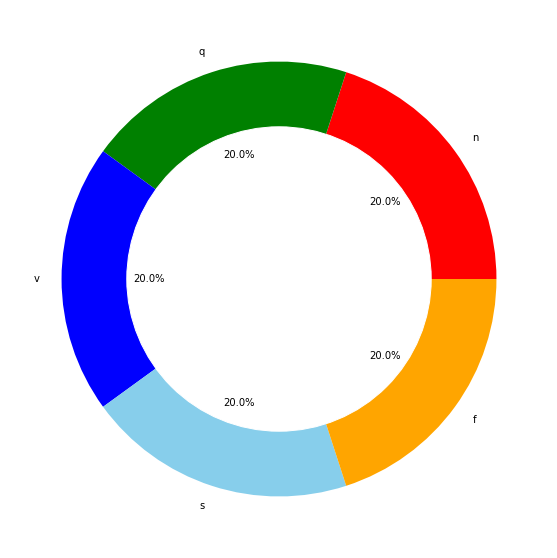

In [ ]:
plt.figure(figsize=(20,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(equilibre, labels=['n','q','v','s','f'], colors=['red','green','blue','skyblue','orange'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

Resample works perfectly we can go on. 

**Classes**

In this part i want to study the differente classes. 

In [ ]:
c=train_df.groupby(187,group_keys=False).apply(lambda train_df : train_df.sample(1))

I take one sample per class and i store it in a datafrmae in order to have an exmeple. 

In [ ]:
c

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
19972,1.000000,0.696970,0.136364,0.102273,0.181818,0.147727,0.098485,0.079545,0.090909,0.083333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
72819,1.000000,0.908722,0.618661,0.338742,0.156187,0.131846,0.144016,0.152130,0.160243,0.172414,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
79870,0.826733,0.766089,0.491337,0.220297,0.086634,0.009901,0.000000,0.037129,0.094059,0.167079,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
81115,1.000000,0.710579,0.309381,0.169661,0.171657,0.145709,0.147705,0.129741,0.143713,0.137725,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
86974,0.812968,0.725686,0.638404,0.569825,0.480050,0.399002,0.312968,0.239401,0.148379,0.134663,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4


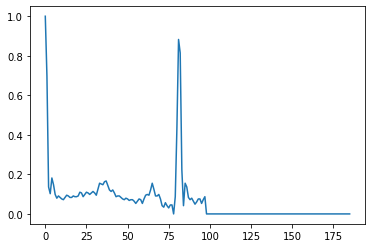

In [ ]:
 plt.plot(c.iloc[0,:186])

Here is a normal beat. I don't have something particular to say on that class.  

In [ ]:
def plot_hist(class_number,size,min_,bins):
    img=train_df.loc[train_df[187]==class_number].values
    img=img[:,min_:size]
    img_flatten=img.flatten()

    final1=np.arange(min_,size)
    for i in range (img.shape[0]-1):
        tempo1=np.arange(min_,size)
        final1=np.concatenate((final1, tempo1), axis=None)
    print(len(final1))
    print(len(img_flatten))
    plt.hist2d(final1,img_flatten, bins=(bins,bins),cmap=plt.cm.jet)
    plt.show()

1300000
1300000


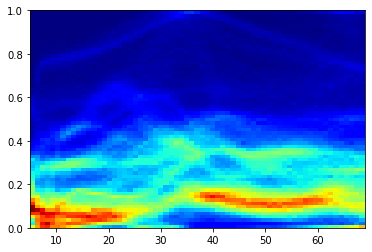

In [ ]:
plot_hist(0,70,5,65)

Here is a representation for all the class. We take all the signal and map them. Like that we have an estimation what the signal can look like.

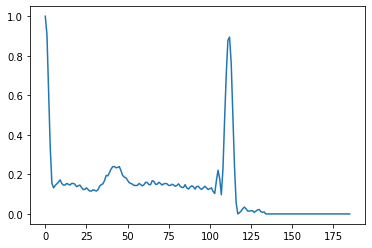

In [ ]:
 plt.plot(c.iloc[1,:186])

900000
900000


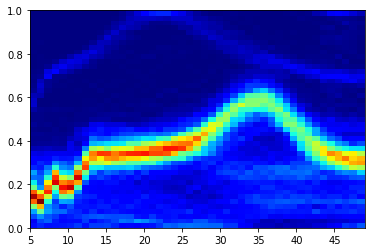

In [ ]:
plot_hist(1,50,5,45)

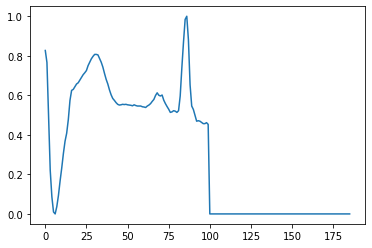

In [ ]:
 plt.plot(c.iloc[2,:186])

900000
900000


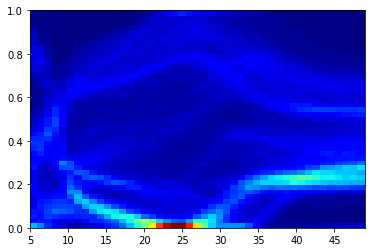

In [ ]:
plot_hist(2,50,5,45)

Here is an exemple of the two classes :

![4-Figure2-1.png](attachment:4-Figure2-1.png)

in the second and third line you have the 2 et 3 class.

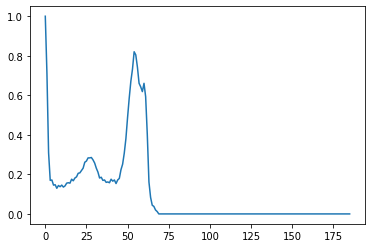

In [ ]:
plt.plot(c.iloc[3,:186])

900000
900000


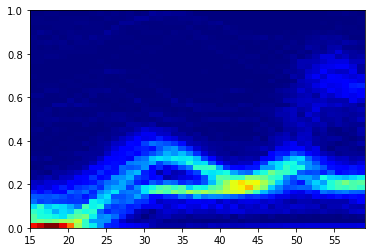

In [ ]:
plot_hist(3,60,15,45)

Fusion beat :
![3-s2.0-B9780124159365000098-f09-10-9780124159365.jpg](attachment:3-s2.0-B9780124159365000098-f09-10-9780124159365.jpg)

Don't really see the difference with the previous one but i'm not an expert of ECG!

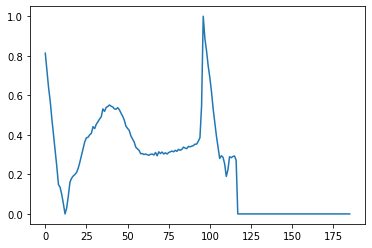

In [ ]:
plt.plot(c.iloc[4,:186])

I will not comment a lot this one because it correspond to other class. 

700000
700000


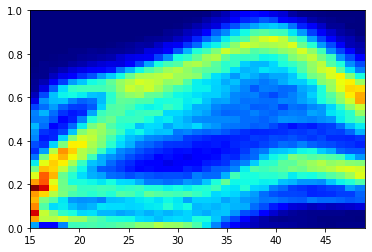

In [ ]:
plot_hist(4,50,15,35)

**Pretreat**

In this part i will speak o n what i do to transform data. 

In [ ]:
def add_gaussian_noise(signal):
    noise=np.random.normal(0,0.5,186)
    return (signal+noise)


I use a fonction ( will depend of the version) where i add a noise to the data to generilize my train.

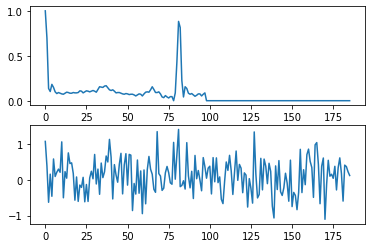

In [ ]:
tempo=c.iloc[0,:186]
bruiter=add_gaussian_noise(tempo)

plt.subplot(2,1,1)
plt.plot(c.iloc[0,:186])

plt.subplot(2,1,2)
plt.plot(bruiter)

plt.show()



In [ ]:
target_train=train_df[187]
target_test=test_df[187]
y_train=to_categorical(target_train)
y_test=to_categorical(target_test)

In [ ]:
X_train=train_df.iloc[:,:186].values
X_test=test_df.iloc[:,:186].values
for i in range(len(X_train)):
    X_train[i,:186]= add_gaussian_noise(X_train[i,:186])
X_train = X_train.reshape(len(X_train), X_train.shape[1],1)
X_test = X_test.reshape(len(X_test), X_test.shape[1],1)

**Network**

In [ ]:
#X_train
#print(X_train.ndim)
print(type(X_train), ' shape = ', X_train.shape)

<class 'numpy.ndarray'>  shape =  (100000, 186, 1)


In [ ]:
def network(X_train,y_train,X_test,y_test):
    

    im_shape=(X_train.shape[1],1)
    inputs_cnn=Input(shape=(im_shape), name='inputs_cnn')
    conv1_1=Convolution1D(64, (6), activation='relu', input_shape=im_shape)(inputs_cnn)
    conv1_1=BatchNormalization()(conv1_1)
    pool1=MaxPool1D(pool_size=(3), strides=(2), padding="same")(conv1_1)
    conv2_1=Convolution1D(64, (3), activation='relu', input_shape=im_shape)(pool1)
    conv2_1=BatchNormalization()(conv2_1)
    pool2=MaxPool1D(pool_size=(2), strides=(2), padding="same")(conv2_1)
    conv3_1=Convolution1D(64, (3), activation='relu', input_shape=im_shape)(pool2)
    conv3_1=BatchNormalization()(conv3_1)
    pool3=MaxPool1D(pool_size=(2), strides=(2), padding="same")(conv3_1)
    flatten=Flatten()(pool3)
    dense_end1 = Dense(64, activation='relu')(flatten)
    dense_end2 = Dense(32, activation='relu')(dense_end1)
    main_output = Dense(5, activation='softmax', name='main_output')(dense_end2)
    
    
    model = Model(inputs= inputs_cnn, outputs=main_output)
    model.compile(optimizer='adam', loss='categorical_crossentropy',metrics = ['accuracy'])
    
    
    callbacks = [EarlyStopping(monitor='val_loss', patience=8),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

    history=model.fit(X_train, y_train,epochs=30,callbacks=callbacks, batch_size=32,validation_data=(X_test,y_test))
    model.load_weights('best_model.h5')
    return(model,history)

In [ ]:
def evaluate_model(history,X_test,y_test,model):
    scores = model.evaluate((X_test),y_test, verbose=0)
    print("Accuracy: %.2f%%" % (scores[1]*100))
    
    print(history)
    fig1, ax_acc = plt.subplots()
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Model - Accuracy')
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()
    
    fig2, ax_loss = plt.subplots()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Model- Loss')
    plt.legend(['Training', 'Validation'], loc='upper right')
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.show()
    target_names=['0','1','2','3','4']
    
    y_true=[]
    for element in y_test:
        y_true.append(np.argmax(element))
    prediction_proba=model.predict(X_test)
    prediction=np.argmax(prediction_proba,axis=1)
    cnf_matrix = confusion_matrix(y_true, prediction)
    

In [ ]:
from keras.layers import Dense, Convolution1D, MaxPool1D, Flatten, Dropout
from keras.layers import Input
from keras.models import Model
from tensorflow.keras.layers import BatchNormalization
#from keras.layers.normalization import BatchNormalization
import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint

model,history=network(X_train,y_train,X_test,y_test)



Epoch 1/30
3125/3125 [==============================] - 113s 36ms/step - loss: 0.8990 - accuracy: 0.6553 - val_loss: 0.9834 - val_accuracy: 0.5503
Epoch 2/30
3125/3125 [==============================] - 110s 35ms/step - loss: 0.7990 - accuracy: 0.6963 - val_loss: 0.8501 - val_accuracy: 0.6310
Epoch 3/30
3125/3125 [==============================] - 114s 37ms/step - loss: 0.7653 - accuracy: 0.7101 - val_loss: 0.8137 - val_accuracy: 0.7746
Epoch 4/30
3125/3125 [==============================] - 115s 37ms/step - loss: 0.7395 - accuracy: 0.7194 - val_loss: 0.9433 - val_accuracy: 0.5895
Epoch 5/30
3125/3125 [==============================] - 117s 38ms/step - loss: 0.7159 - accuracy: 0.7296 - val_loss: 0.8316 - val_accuracy: 0.7684
Epoch 6/30
3125/3125 [==============================] - 113s 36ms/step - loss: 0.6930 - accuracy: 0.7374 - val_loss: 0.9854 - val_accuracy: 0.5717
Epoch 7/30
3125/3125 [==============================] - 117s 38ms/step - loss: 0.6666 - accuracy: 0.7483 - val_loss: 1

Accuracy: 74.51%


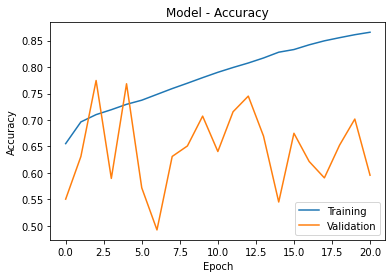

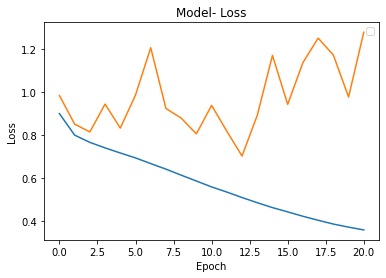

685/685 [==============================] - 6s 8ms/step


In [ ]:
evaluate_model(history,X_test,y_test,model)
y_pred=model.predict(X_test)


i take the next function from : https://www.kaggle.com/coni57/model-from-arxiv-1805-00794

Normalized confusion matrix


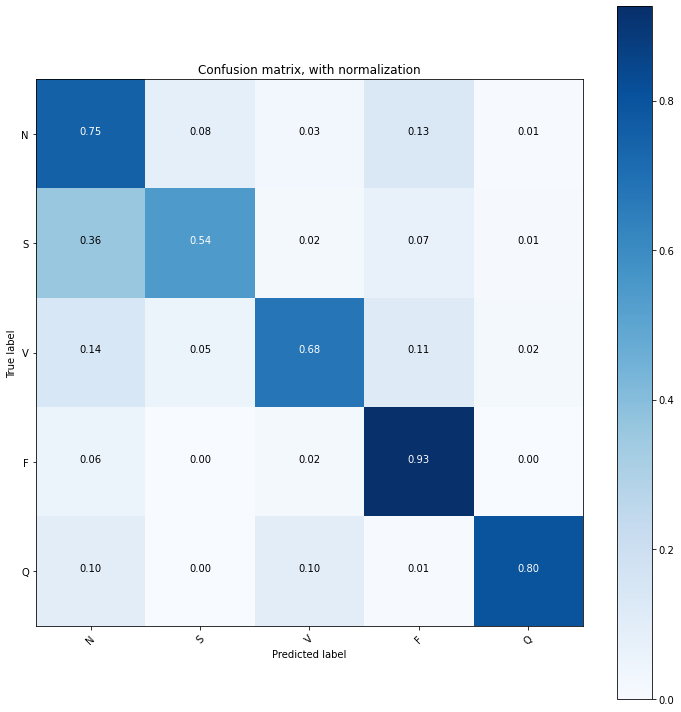

In [ ]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cnf_matrix, classes=['N', 'S', 'V', 'F', 'Q'],normalize=True,
                      title='Confusion matrix, with normalization')
plt.show()



We underlign that two class(supraventricular and fusion) is weeker than the other. maybe due to less exemple in the starter dataset. I will try to improve in the next version.